<div>
    <a href="../notebook/2. Data Analysis.ipynb" style="float: left; padding: 10px; background-color: #007bff; color: white;">Previous</a>
    <a href="../notebook/1. Business & Data Understanding.ipynb" style="float: right; padding: 10px; background-color: #007bff; color: white"> Next </a>
</div>

## Section 4 | Data Modeling

Data modeling is the process of selecting and training a machine learning (ML) model to learn patterns from data so it can make predictions or decisions.

---

#### Data ETL

Proses ETL yang serupa dengan bagian `Data Analysis` sebelumnya juga dilakukan dalam bagian ini karena:
1. Data yang relevan untuk membangun model ML juga bersumber dari dataset yang sama, dan
2. Lebih memastikan bahwa manipulasi data yang dilakukan dalam bagian sebelumnya tidak berdampak ke dalam bagian-bagian berikutnya

In [ ]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
  
iranian_churn = fetch_ucirepo(id=563) 
  
features = iranian_churn.data.features 
target = iranian_churn.data.targets 

dataset = pd.concat(
    objs=[features, target],
    axis=1
)

dataset.head(n=5)

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


### Data Preprocessing

[Data preprocessing](https://en.wikipedia.org/wiki/Data_preprocessing) can refer to manipulation, filtration or augmentation of data before it is analyzed —in this case, by the machine learning algorithm.

* The preprocessing pipeline used can often have large effects on the conclusions drawn from the downstream analysis. Thus, representation and quality of data perlu dieksplor before running any analysis, sebagaimana yang telah dilakukan pada keseluruhan bagian `Data Analysis` sebelumnya.
* Often, data preprocessing is the most important phase of a machine learning project. If there is a high proportion of irrelevant and redundant information present or noisy and unreliable data, then knowledge discovery during the training phase may be more difficult. 
* The well-known concept of “garbage in — garbage out” applies 100% to any task in machine learning. Any experienced professional can recall numerous times when a simple model trained on high-quality data was proven to be better than a complicated multi-model ensemble built on data that wasn’t clean.

Sehingga pada dasarnya bagian ini adalah pengulangan dan penambahan dari temuan anomali dalam dataset yang ditemukan dari bagian sebelumnya.

#### Train-Test Split

Learning the parameters of a prediction —in this context, classification— function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. 

This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set `X_test`, `y_test`.

In [ ]:
from sklearn.model_selection import train_test_split

df = dataset.copy()
df = df.drop_duplicates(keep="first")

# Arbitrary random state ditetapkan sesuai dengan bagian "Data Analysis" sebelumnya
arbitrary_random_state = 0

X, y = df.drop(columns="Churn"), df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=arbitrary_random_state, 
    stratify=y
)

print("Dataset Dimensionality:")
display(
    pd.DataFrame(
        data={
            "Dataset": ["X_train", "X_test", "y_train", "y_test"],
            "Row (n)": [X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]],
            "Row (%)": [round(number=X_train.shape[0] / df.shape[0] * 100), 
                        round(number=X_test.shape[0] / df.shape[0] * 100),
                        round(number=y_train.shape[0] / df.shape[0] * 100),
                        round(number=y_test.shape[0] / df.shape[0] * 100)]
        }
    ).set_index(keys="Dataset")
)

print("Class Proportions:")
display(
    pd.DataFrame(
        data={
            "Dataset": round(number=y.value_counts(normalize=True) * 100, ndigits=3),
            "y_train": round(number=y_train.value_counts(normalize=True) * 100, ndigits=3),
            "y_test": round(number=y_test.value_counts(normalize=True) * 100, ndigits=3)
        }
    ).rename(
        index={
            0: "False (%)",
            1: "True (%)"
        }
    ).T
)

Dataset Dimensionality:


,Row (n),Row (%)
Dataset,,
X_train,2137,75
X_test,713,25
y_train,2137,75
y_test,713,25


Class Proportions:


Churn,False (%),True (%)
Dataset,84.351,15.649
y_train,84.371,15.629
y_test,84.292,15.708


Note:
* *Redundant column and duplicated data from previous findings are propagated here, since any duplications would potentially not be detected after splitting the dataset.*
* `X` designated sebagai kumpulan feature dalam dataset, sedangkan `y` adalah instance dari target variabel `Churn`
* Kedua variabel instance ini kemudian dipisahkan lebih jauh menggunakan `train_test_split`.
    * *pada bagian ini dan seterusnya, penerapan dari metode machine learning yang digunakan akan berfokus dari library [Scikit-learn](https://scikit-learn.org/stable/)*
    * fungsi ini sebenarnya adalah wrapper dari `ShuffleSplit` iterator dalam library Scikit-learn yang generate a user defined number of independent train / test dataset splits. Samples are first shuffled and then split into a pair of train and test sets.
    * sample yang dimaksud adalah instance/row dari dataset, sehingga proses split tidak mengubah jumlah kolom dari dataset awal
    * It is possible to control the randomness for reproducibility of the results by modifying the `random_state` parameter. dalam project ini, yang diterapkan adalah passing an integer number of `arbitrary_random_state` from previous section.
* secara default, parameter `test_size` dalam `train_test_split` diatur sebanyak `0.25`, sehingga ukuran proporsi dari tiap `X_test` dan `y_test` adalah `25%` dari keseluruhan dataset
* sedangkan parameter `stratify` digunakan untuk returns the data `y` in a stratified fashion: the set contains approximately the same percentage of samples of each target class as the complete set. jika dibandingkan antara proporsi target `y` pada `Dataset` original dengan proporsi target setelah split menjadi `y_train` dan `y_test`, nilainya approximately the same

#### Custom Preprocessor

Handling problems in the dataset is done by creating a class that contains all the handling functions, which will later be integrated into a pipeline along with preprocessing/feature engineering and used in the experimental setup. Also some algorithms take noise (non-informative features) as a signal and overfit. Therefore, it would be necessary to select features before inputting them into the machine learning model

Within the class, there are functions to handle issues yang telah disampaikan sebelumnya, yakni:
1. Modifying inconsistent column/feature names,
2. Removing dependent variable

*(data tipe tidak perlu casted to the appropriate type, karena untuk machine learning, yang diperlukan justru tipe numerik sesuai tipe data original)*

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        X = X.copy()

        X_columns_splitted = X.columns.str.split()
        X.columns = X_columns_splitted.str.join(sep=" ")

        X = X.drop(columns="Age")

        return X

*Notes:*

* *`BaseEstimator` class of Scikit-Learn enables hyperparameter tuning by adding the `set_params` and `get_params` methods.*
* *`TransformerMixin` class adds `fit_transform` method without explicitly defining it, sebagaimana dijelaskan berikut ini*
* *The class has three methods:*
    1. *`__init__` is the first method that is called upon creating an instance/object of the class. This is used to initialize the class attributes.*
    2. *`fit` method learns model parameters —in this context, values and data types for each features— from a training set. This method always returns `self`.*
    3. *`transform` method applies this transformation model to unseen data, by taking in an array or dataframe of as input and applies modifications specified inside the class and returns it.*

Berikutnya variable instance dibuat dari `CustomPreprocessor` Class yang telah didefinisikan sebelumnya, untuk memanggil fungsi `fit_transform` dalam Class tersebut. Sebagai contoh, digunakan `X_train` untuk melihat apakah input berhasil dimodifikasi sesuai fungsi di dalam Class tersebut.

In [ ]:
custom_preprocessor = CustomPreprocessor()
X_train_preprocessed, X_test_preprocessed = custom_preprocessor.fit_transform(X=X_train), custom_preprocessor.fit_transform(X=X_test)

Dan berikut ditampilkan perbandingan karakteristik data sebelum dan sesudah preprocess:

In [ ]:
print("Column Name (Before Preprocessed):")
display(X_train.columns.to_list())

print("Column Name (After Preprocessed):")
display(X_train_preprocessed.columns.to_list())

Column Name (Before Preprocessed):


['Call  Failure',
 'Complains',
 'Subscription  Length',
 'Charge  Amount',
 'Seconds of Use',
 'Frequency of use',
 'Frequency of SMS',
 'Distinct Called Numbers',
 'Age Group',
 'Tariff Plan',
 'Status',
 'Age',
 'Customer Value']

Column Name (After Preprocessed):


['Call Failure',
 'Complains',
 'Subscription Length',
 'Charge Amount',
 'Seconds of Use',
 'Frequency of use',
 'Frequency of SMS',
 'Distinct Called Numbers',
 'Age Group',
 'Tariff Plan',
 'Status',
 'Customer Value']

*Notes:*
1. *Custom preprocessor succesfully implemented, and*
2. *Input variables are transformed according to the defined functions:* 
    * *Fixing inconsistent labelling*
    * *Removing dependent variables*

Setelah dataset dipersiapkan dan preprocessed, tahapan berikutnya yakni pemodelan machine learning dapat dimulai. T. Mitchell’s book “Machine Learning” (1997) gives a classic, general definition of machine learning as follows:

>A computer program is said to learn from experience $E$ with respect to some class of tasks $T$ and performance measure $P$, if its performance at tasks in $T$, as measured by $P$, improves with experience $E$.

* In the various problem settings, $T$, $P$, and $E$ can refer to completely different things. untuk project ini, tasks T in machine learning yang akan diimplementasikan adalah classification of an instance to one of the categories based on its features;

* Experience $E$ refers to data (we can’t go anywhere without it). Machine learning algorithms can be divided into those that are trained in supervised or unsupervised manner. In unsupervised learning tasks, one has a set consisting of instances described by a set of features. In supervised learning problems, there’s also a target variable, which is what we would like to be able to predict, known for each instance in a training set.

* Classification is a  supervised learning problems. For example, as a Telecom institution, we may want to predict churned customers based on the data accumulated about our clients. 
    * Here, the experience $E$ is the available training data: a set of instances (clients), a collection of features (such as complains, charge amounts, frequency of telecommunication usages, etc.) for each, and a target variable (whether they left the company or not). 
    * This target variable is just a fact of churn status (`True` or `False`), so this is a binary classification problem.

### Baseline Model

When doing supervised learning, a simple sanity check consists of comparing one’s estimator against simple rules of thumb
* Hal ini selaras dengan apa yang telah dilakukan dalam `Target Variable` pada bagian `Exploratory Data Analysis` sebelumnya. 
* Sedangkan dalam konteks predictive modeling, library `sklearn` menyediakan [`DummyClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) which serves as a simple baseline to compare against other more complex classifiers. This classifier in particular makes predictions that ignore the input features.

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(
    strategy="constant",
    constant=0
)

The specific behavior of the baseline is selected with the `strategy` parameter.
* `sklearn` menyediakan beberapa `strategy` untuk `DummyClassifier`: `most_frequent, prior, stratified, uniform, constant`
* All strategies make predictions that ignore the input feature values passed as the `X` argument to `fit` and `predict`. The predictions, however, typically depend on values observed in the `y` parameter passed to fit.
* selaras dengan apa yang telah disampaikan pada bagian `Target Label` sebelumnya, `strategy` yang akan digunakan kali ini adalah `constant`
    * this `strategy` always predicts a constant label that is provided by the user. 
    * dengan menambahkan parameter `constant=0`, `DummyClassifier` akan selalu memprediksi label `0` (`False` atau `Non-churn`) kepada dataset yang diberikan (`X` dan `y`).

#### Pipeline

[`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class in `sklearn` allows us to sequentially apply a list of transformers to preprocess the data and, if desired, conclude the sequence with a final predictor for predictive modeling.

In [ ]:
from sklearn.pipeline import Pipeline

dummy_pipeline = Pipeline(
    steps=[("preprocessor", custom_preprocessor),
           ("classifier", dummy_classifier)]
)

*Note:*
* *Intermediate `steps` of the pipeline must be "transforms", that is, they must implement `fit` and `transform` methods. dapat dilihat bahwa `step` pertama dalam `Pipeline` di atas adalah `custom_preprocessor` yang telah diimplementasikan utamanya dengan `TransformerMixin` (memungkinkan user untuk menerapkan `fit` dan `transform` kepada dataset yang diinputkan)*
* *The final estimator only needs to implement `fit`. Untuk `pipeline` awal yang akan digunakan oleh baseline model, final estimator yang digunakan (the last `step`) adalah `DummyClassifier`*

Pipeline can be used to [chain multiple estimators into one](https://scikit-learn.org/stable/modules/compose.html#pipeline). This is useful as there is often a fixed sequence of steps in processing the data (in this example, we use simple preprocessing before classifying the data). Pipeline serves multiple purposes here:
* *Convenience and encapsulation*: we only have to call `fit` and `predict` once on our data to fit a whole sequence of [estimators](https://scikit-learn.org/stable/glossary.html#term-estimator). sehingga tidak perlu memanggil `fit_transform` pada `custom_preprocessor` lalu memanggil `fit` kembali pada `classifier` yang hendak digunakan
* *Joint parameter selection*: we can grid search over parameters of all estimators in the pipeline at once. sebagaimana yang telah sedikit disinggung pada bagian `Custom Preprocessor`, hyperparameter tuning akan dilakukan pada model prediktif untuk mencari parameter terbaik yang dapat memaksimalkan performance metric bersama dengan pipeline ini.
* *Safety*: pipelines help avoid leaking statistics from our test data into the trained model, by ensuring that the same samples are used to train the transformers and predictors. bagian berikut menunjukkan bahwa hanya `train` set yang digunakan sebagai input ke dalam `pipeline`.

#### Fit, Transform, & Predict

In [ ]:
dummy_pipeline.fit(
    X=X_train,
    y=y_train
)

Pipeline(steps=[('preprocessor', CustomPreprocessor()),
                ('classifier',
                 DummyClassifier(constant=0, strategy='constant'))])

*Note:*
* *Calling `fit` on the pipeline is the same as calling `fit` on each transfomer/estimator in turn, `transform` the input, and pass it on to the next step.*
* *The pipeline has all the methods that the last estimator in the pipeline has, i.e. if the last estimator is a classifier, `Pipeline` can be used as a classifier.*

Output di atas menunjukkan bahwa:
1. `dummy_pipeline` yang digunakan is `fitted` to `CustomPreprocessor` class, which `transform` the input `X_train` data.
2. The function is also used to `fit` the transformed data using the final `DummyClassifier` estimator.

This function returns `self`, that is, the pipeline itself with fitted steps as defined. Pipeline ini kemudian dapat digunakan untuk melakukan prediksi kepada data baru dengan memanggil fungsi `predict`.

In [ ]:
y_pred_dummy = dummy_pipeline.predict(X=X_test)
y_pred_dummy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Proses `Train-Test Split` sebelumya telah memisahkan antara `X` dengan `y` masing-masing menjadi dataset untuk `Train` dan `Test`, sehingga dengan memasukkan `X_test` ke dalam fungsi `predict` dari Pipeline, outputnya akan menghasilkan an array of labels which corresponds to the number of samples in `X_test`.
* Untuk `DummyClassifier`, the `predict` method completely ignores the input data, sehingga prediksi yang dihasilkan akan bergantung pada parameter `strategy` yang ditentukan. Untuk strategi `constant` yang digunakan kali ini, the classifier akan terus menerus memprediksi nilai `0` untuk setiap sampel yang diberikan.
* Hasil prediksi ini dapat dibandingkan dengan the true label in `y_test` sebagaimana ditampilkan berikut ini untuk melihat performa dari classifier yang digunakan.

In [ ]:
y_test.to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Evaluation Metric

When new machine learning models are created, it is necessary to [compare their performance to the already existing ones](https://www.nature.com/articles/s41598-024-56706-x#Abs1). Evaluation serves two purposes: methods that do not perform well can be discarded, and the ones that seem promising can be further optimized. 

In supervised learning, we first divide our data for training and test sets, use the training data for training (and validation; explored further in the next section) of the model, predict all the instances of the test data, and compare the obtained predictions to the corresponding ground-truth values of the test set. In this way, we can estimate whether the predictions of a new model are better than the predictions of a human or existing models in our test set.

In a binary classification task, the instances of data are typically predicted to be either positive or negative so that a positive label is interpreted as presence of abnormality or some other deviation while a negative instance does not differ from the baseline in this respect. Each predicted binary label has therefore four possible designations: 
1. True positive (TP) is a correctly predicted positive outcome, 
2. True negative (TN) is a correctly predicted negative outcome, 
3. False positive (FP) is a negative instance predicted to be positive, and 
4. False negative (FN) is a positive instance predicted to be negative. 

A confusion matrix, here a $ 2 \text{x} 2$-matrix containing the counts of TP, TN, FP, and FN observations as shown below, can be used to compute several metrics for the evaluation of the binary classifier.

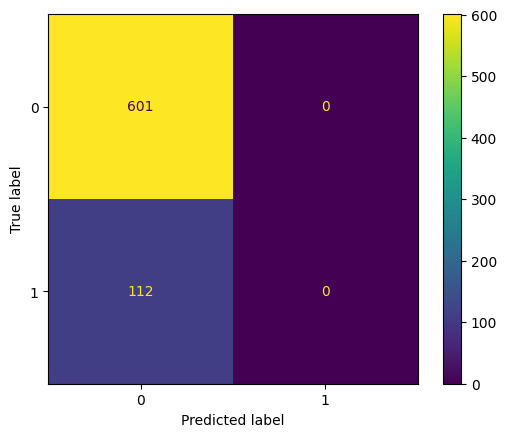

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred_dummy
)

plt.show()

Tampak bahwa `DummyClassifier` sebagai baseline model memprediksi dengan tepat `601` observasi pelanggan Telecom sebagai non-churn (True negative: `0` true label that is also predicted as `0`), tetapi salah mengklasifikasi `112` pelanggan (False negative: `1` true label yang tetap diprediksi sebagai `0`).

Karena model ini hanya menghasilkan negative predictions, maka Negative Prediction Value (NPV) dapat digunakan untuk mengukur how many predictions out of all negative predictions were correct. It tells us what is the fraction of correctly predicted non-churned customers in all non-churned predictions.

$$ {NPV} = \frac{TN}{TN + FN} $$

In [ ]:
# TN = 601
# TN + FN = 601 + 112

601 / (601 + 112)

0.8429172510518934

Nilai NPV tersebut selaras dengan apa yang telah disampaikan dalam `Target Variable` in the previous `Section 3`...

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score_dummy = accuracy_score(
    y_true=y_test,
    y_pred=y_pred_dummy
)

accuracy_score_dummy

0.8429172510518934

In [ ]:
from sklearn.metrics import brier_score_loss, log_loss

pd.DataFrame(
    data=[
        brier_score_loss(
            y_true=y_test,
            y_proba=dummy_pipeline.predict_proba(X=X_test)[:, 1]
        ),
        log_loss(
            y_true=y_test,
            y_pred=dummy_pipeline.predict_proba(X=X_test)
        )
    ],
    columns=["Score"],
    index=[
        "Brier Score",
        "Log Loss"
    ]
)

,Score
Brier Score,0.157083
Log Loss,5.661836


In [ ]:
dummy_pipeline.predict_proba(X=X_test)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], shape=(713, 2))

we begin our overview of classification methods with one of the most popular ones – a decision tree.

### Decision Tree

Decision trees are used in everyday life decisions, not just in machine learning. An example of [flow diagram](https://en.wikipedia.org/wiki/Flowchart) are actually visual representation of decision tree.

The decision tree as a machine learning algorithm is essentially the same thing as the diagram shown above; we incorporate a stream of logical rules of the form “feature $a$ value is less than $x$ and feature $b$ value is less than $y$ … -> Category 1” into a tree-like data structure.

Some advantages of decision trees yang berkaitan dengan karakteristik data input are:
* Requires little data preparation. Other predictive techniques often require data normalization (handling data with different magnitudes and/or containing outliers).
* Performs well even if its assumptions are somewhat violated by the true model from which the data were generated. Decision tree sendiri merupakan metode supervised learning non-parametrik, sehingga tidak mempermasalahkan asumsi normalitas dalam data input.

Tetapi ia juga memiliki kelemahan, yakni decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=arbitrary_random_state)

dt_pipeline = Pipeline(
    steps=[("preprocessor", custom_preprocessor),
           ("classifier", dt_classifier)]
)

dt_pipeline.fit(
    X=X_train,
    y=y_train
)

Pipeline(steps=[('preprocessor', CustomPreprocessor()),
                ('classifier', DecisionTreeClassifier(random_state=0))])

In [ ]:
dt_pipeline["classifier"].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 0,
 'splitter': 'best'}

In [ ]:
path = dt_pipeline["classifier"].cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

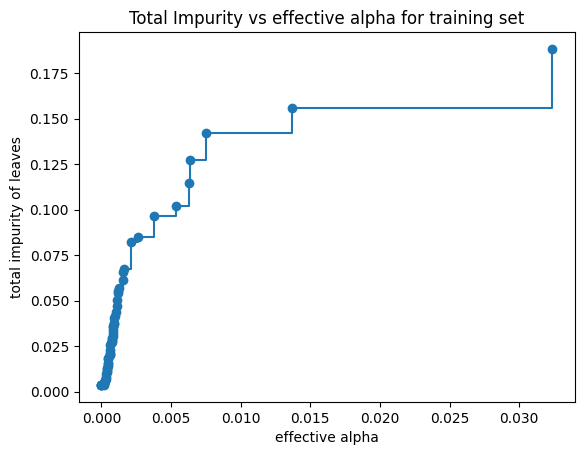

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
ccp_alphas

array([ 0.00000000e+00, -1.08420217e-19,  0.00000000e+00,  2.16840434e-19,
        2.07975875e-04,  2.16641536e-04,  2.26041576e-04,  2.33496336e-04,
        2.59969843e-04,  2.89025297e-04,  3.05846875e-04,  3.68290612e-04,
        3.71516752e-04,  4.09452504e-04,  4.21151146e-04,  4.25405198e-04,
        4.41948734e-04,  4.44548432e-04,  4.48447980e-04,  4.51233371e-04,
        4.59437614e-04,  4.61354934e-04,  6.23927624e-04,  6.23927624e-04,
        6.23927624e-04,  6.55423489e-04,  6.57353438e-04,  6.89156421e-04,
        7.48713149e-04,  7.48713149e-04,  7.48713149e-04,  7.79909530e-04,
        8.25144283e-04,  8.25786562e-04,  8.26908130e-04,  8.31903499e-04,
        8.54146908e-04,  8.96895960e-04,  9.02378825e-04,  9.21276392e-04,
        9.59888653e-04,  1.07682568e-03,  1.10059792e-03,  1.14981201e-03,
        1.21395894e-03,  1.23055080e-03,  1.24785525e-03,  1.52248736e-03,
        1.57806036e-03,  1.63781001e-03,  2.12397876e-03,  2.65049254e-03,
        3.76992613e-03,  

In [ ]:
ccp_alphas_series = pd.Series(data=ccp_alphas)
ccp_alphas_series = ccp_alphas_series.drop_duplicates()
ccp_alphas = ccp_alphas_series.to_numpy()
ccp_alphas

array([ 0.00000000e+00, -1.08420217e-19,  2.16840434e-19,  2.07975875e-04,
        2.16641536e-04,  2.26041576e-04,  2.33496336e-04,  2.59969843e-04,
        2.89025297e-04,  3.05846875e-04,  3.68290612e-04,  3.71516752e-04,
        4.09452504e-04,  4.21151146e-04,  4.25405198e-04,  4.41948734e-04,
        4.44548432e-04,  4.48447980e-04,  4.51233371e-04,  4.59437614e-04,
        4.61354934e-04,  6.23927624e-04,  6.55423489e-04,  6.57353438e-04,
        6.89156421e-04,  7.48713149e-04,  7.79909530e-04,  8.25144283e-04,
        8.25786562e-04,  8.26908130e-04,  8.31903499e-04,  8.54146908e-04,
        8.96895960e-04,  9.02378825e-04,  9.21276392e-04,  9.59888653e-04,
        1.07682568e-03,  1.10059792e-03,  1.14981201e-03,  1.21395894e-03,
        1.23055080e-03,  1.24785525e-03,  1.52248736e-03,  1.57806036e-03,
        1.63781001e-03,  2.12397876e-03,  2.65049254e-03,  3.76992613e-03,
        5.35260885e-03,  6.32101828e-03,  6.37555659e-03,  7.52529509e-03,
        1.36771241e-02,  

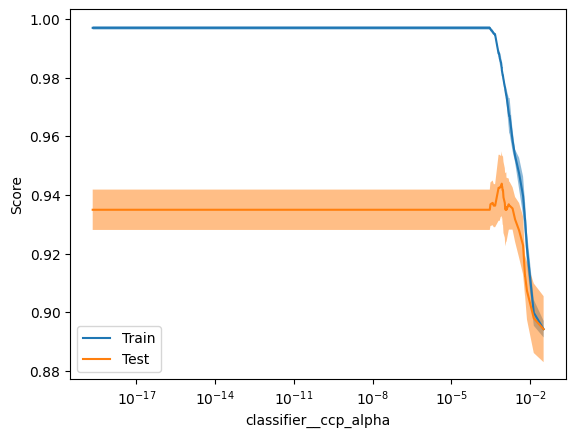

In [ ]:
from sklearn.model_selection import ValidationCurveDisplay

ValidationCurveDisplay.from_estimator(
    estimator=dt_pipeline, 
    X=X_train, 
    y=y_train, 
    param_name="classifier__ccp_alpha", 
    param_range=ccp_alphas[2:-1], 
    cv=None,
    n_jobs=-1 
)

plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

dt_params = {
    "classifier__ccp_alpha": ccp_alphas[2:-1]
}

scoring_dict = {
    "Brier Score": make_scorer(score_func=brier_score_loss),
    "Log Loss": make_scorer(score_func=log_loss)
}

best_score = list()
best_params = list()

for _, scoring in scoring_dict.items():
    dt_grid = GridSearchCV(
        estimator=dt_pipeline,
        param_grid=dt_params,
        scoring=scoring,
        n_jobs=-1,
        cv=None
    )

    dt_grid.fit(
        X=X_train,
        y=y_train
    )

    best_score.append(dt_grid.best_score_)
    for _, param in dt_grid.best_params_.items():
        best_params.append(param)

In [ ]:
pd.DataFrame(
    data=[
        best_score, 
        best_params
    ],
    index=[
        "Score",
        "Alpha"
    ],
    columns=[scoring_name for scoring_name, _ in scoring_dict.items()]
).T

,Score,Alpha
Brier Score,0.105761,0.032376
Log Loss,3.812002,0.032376
